In [ ]:
using Revise
using Scattering
using SpecialFunctions
using FastGaussQuadrature
using LinearAlgebra
using StaticArrays
using HCubature
using Distributions
using BenchmarkTools
using Test
using Plots

# Testing Form Factor Calculations

## Testing form factor of a sphere

In [2]:
q1 = QVector([1, 0, 3.0])
q2 = QVector([1, 1, 2.0])
r = RVector([2.0, -3.0, 4.0])
r0 = [0.0, 0, 0]
qs = [q1, q2]

2-element Array{SArray{Tuple{3},Float64,1,3},1}:
 [1.0, 0.0, 3.0]
 [1.0, 1.0, 2.0]

### Testing form factor for directional q

In [3]:
s = Sphere(2.0, 1.0, 1.0, r)

Sphere{Float64}(2.0, 33.510321638291124, 1.0, 1.0, [2.0, -3.0, 4.0])

In [4]:
# test single q
formfactor(s, q1)

-0.34111678629762715 - 2.4712569268727873im

In [5]:
formfactor(s, q2)

-1.2192506815289956 - 1.062513546853694im

In [6]:
# test a list of q
formfactor(s, qs)

2-element Array{Complex{Float64},1}:
 -0.34111678629762715 - 2.4712569268727873im
  -1.2192506815289956 - 1.062513546853694im 

In [7]:
s0 = Sphere(2.0, 1.0, 1.0, r0)

Sphere{Float64}(2.0, 33.510321638291124, 1.0, 1.0, [0.0, 0.0, 0.0])

In [8]:
formfactor(s0, qs)

2-element Array{Complex{Float64},1}:
  -2.494688650014417 - 0.0im
 -1.6172529986543656 - 0.0im

In [10]:
# test translating a sphere from origin to location r.
s1 = Scattering.translate(s0, r)
@test formfactor(s1, qs) ≈ formfactor(s, qs)

Test Passed

### Testing form factor for isotropic q

In [11]:
qxs = 0.01:0.01:10
qs = [QVector([qx, 0, 0]) for qx in qxs]
r0 = [0.0, 0, 0]
s0 = Sphere(1.0, 15.0, 15.0, r0)

Sphere{Float64}(1.0, 4.1887902047863905, 15.0, 15.0, [0.0, 0.0, 0.0])

In [13]:
Fa = formfactor(s0, qs)
F2a = real(Fa .* conj(Fa))

r = RVector([2.0, -3.0, 4.0])
s1 = Scattering.translate(s0, r)
Fb = formfactor(s1, qs)
F2b = real(Fb .* conj(Fb))
# squared form factor of a sphere should be invariant under translation.
@test F2a ≈ F2b

Test Passed

In [14]:
using Plots

plot(qxs, F2a, xaxis=:log, yaxis=:log)
plot!(qxs, F2b, xaxis=:log, yaxis=:log)
# plot(qxs, F2a)

### Testing form factor for size polydispersity

In [16]:
qxs = 0.01:0.01:10
r0 = [0.0, 0, 0]
s0 = Sphere(1.0, 15.0, 15.0, r0)

Sphere{Float64}(1.0, 4.1887902047863905, 15.0, 15.0, [0.0, 0.0, 0.0])

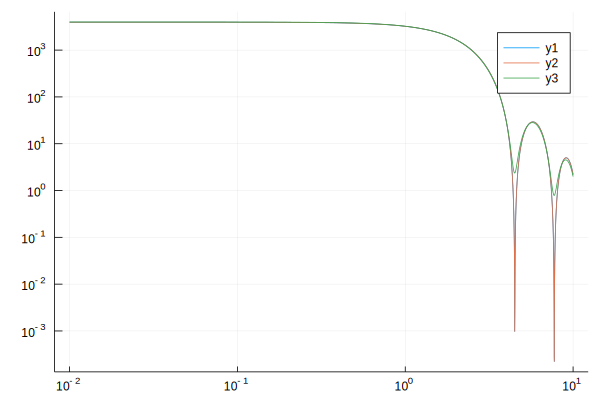

In [22]:
function F2(s0, r, q)
    s = Sphere(r, s0.ρ, s0.Δρ, s0.origin)
    formfactor_squared(s, QVector([q,0,0]))
end

σR = 0.04
d = Normal(s0.R, σR)
# Default number of points: 11, default algorithm QuadGKGauss
F2d = [size_average(r->F2(s0,r,q), s0.R-2.5σR, s0.R+2.5σR, d) for q in qxs]

plot!(qxs, F2d, xaxis=:log, yaxis=:log)

## Testing form factor of a cylinder

### Testing form factor for directional q

In [23]:
q1 = QVector([1, 0, 3.0])
q2 = QVector([1, 1, 2.0])
r = RVector([2.0, -3.0, 4.0])
r0 = [0.0, 0, 0]
qs = [q1, q2]
R0 = RotationMatrix(EulerAngle(0.0, 0.0, 0.0))

RotationMatrix{Float64}(Real[0.0, 0.0, 0.0], [1.0 -0.0 0.0; 0.0 1.0 0.0; -0.0 0.0 1.0])

In [24]:
c0 = Cylinder(1.0, 6.0, 15.0, 15.0, r0, R0)

Cylinder{Float64}(1.0, 6.0, 18.84955592153876, 15.0, 15.0, [0.0, 0.0, 0.0], RotationMatrix{Float64}(Real[0.0, 0.0, 0.0], [1.0 -0.0 0.0; 0.0 1.0 0.0; -0.0 0.0 1.0]))

In [25]:
formfactor(c0, q1)

11.394743845451115 + 0.0im

In [26]:
formfactor(c0, qs)

2-element Array{Complex{Float64},1}:
  11.394743845451115 + 0.0im
 -10.138525609460205 - 0.0im

In [28]:
c1 = Scattering.translate(c0, r)

Cylinder{Float64}(1.0, 6.0, 18.84955592153876, 15.0, 15.0, [2.0, -3.0, 4.0], RotationMatrix{Float64}(Real[0.0, 0.0, 0.0], [1.0 -0.0 0.0; 0.0 1.0 0.0; -0.0 0.0 1.0]))

In [29]:
formfactor(c1, q1)

1.5580855756178182 + 11.287717069562728im

In [30]:
formfactor(c1, qs)

2-element Array{Complex{Float64},1}:
 1.5580855756178182 + 11.287717069562728im
 -7.643457312689375 - 6.660875456182597im 

In [31]:
w = [1.0, 2.0, 3.0]
normalize!(w)
a = [0, 1, 2]
u = cross(w, a)
normalize!(u)
v = cross(w, u)
normalize!(v)
M = RotationMatrix(hcat(u, v, w))
w # expected cylinder axis in the reference frame

3-element Array{Float64,1}:
 0.2672612419124244
 0.5345224838248488
 0.8017837257372732

In [32]:
c2 = Scattering.rotate(c1, M) # rotate conflict with Plots.rotate

Cylinder{Float64}(1.0, 6.0, 18.84955592153876, 15.0, 15.0, [2.0, -3.0, 4.0], RotationMatrix{Float64}(Real[-0.818756237602561, 0.6405223126794245, 2.0344439357957027], [0.408248290463863 -0.816496580927726 0.408248290463863; 0.8728715609439696 0.21821789023599242 -0.4364357804719848; 0.2672612419124244 0.5345224838248488 0.8017837257372732]))

In [33]:
@test w ≈ transpose(c2.orientation.R)[:, 3] # the cylinder axis in the reference frame

Test Passed

In [34]:
formfactor(c2, q1)

3.248947786392282 + 23.537348628644096im

In [35]:
formfactor(c2, qs)

2-element Array{Complex{Float64},1}:
  3.248947786392282 + 23.537348628644096im
 23.100272945301803 + 20.130686258564413im

### Testing form factor for isotropic q

#### 1. Testing various algorithms

In [50]:
qs = 0.01:0.1:20
# qs = [5.0]

0.01:0.1:19.91

In [51]:
r0 = [0.0, 0, 0]
R0 = RotationMatrix(EulerAngle(0.0, 0.0, 0.0))
c0 = Cylinder(10.0, 1.0, 1.0, 1.0, r0, R0)
function F2(θ, φ, c, q)
    z = formfactor(c, QVector([-q*sin(θ)*cos(φ),q*sin(θ)*sin(φ),q*cos(θ)]))
    real(z * conj(z))
end
@time F2oa = [orientation_average((θ,φ)->F2(θ,φ,c0,q), Nθ=1000, Nφ=1) for q in qs];
@time F2oac = [orientation_average((θ,φ)->F2(θ,φ,c0,q), algo=HCubature2D()) for q in qs];

function fc(θ, φ, q, R, L)
    qx = -q*sin(θ)*cos(φ)
    qy = q*sin(θ)*sin(φ)
    qz = q*cos(θ)
    qzL = qz * L / 2
    qrR = √(qx^2 + qy^2) * R
    (2*besselj1(qrR)/qrR*sinc(qzL/π))^2
end

function f1(θ, φ)
    x = sin(θ)*cos(φ)
    y = sin(θ)*sin(φ)
    z = cos(θ)
    1 + x + y^2 + x^2*y + x^4 + y^5 + x^2*y^2*z^2
end

# @test orientation_average(f1) * 4π ≈ 216*π/35

# F2oa = zeros(length(qs))
# i = 1
# for q in qs
#     fp(θ, φ) = fc(θ, φ, q, c0.R, c0.L)
#     F2oa[i] = orientation_average(fp, Nθ=40, Nφ=81)
#     i += 1
# end
@time F2ob = [orientation_average((θ,φ)->fc(θ, φ, q, c0.R, c0.L), Nθ=200, Nφ=4) for q in qs];
F2ob *= (c0.V*c0.Δρ)^2

@test F2oa[1] ≈ F2ob[1]
F2oa[1], F2oac[1]

  3.828140 seconds (13.43 M allocations: 632.682 MiB, 8.66% gc time)
  9.897576 seconds (160.09 M allocations: 5.682 GiB, 23.87% gc time)
  3.086477 seconds (5.65 M allocations: 291.428 MiB, 9.85% gc time)


(98531.41373239426, 98531.41373240991)

In [52]:
fcb(x, q) = fc(x[1], x[2], q, c0.R, c0.L) * sin(x[1])
@time F2oc = [hcubature(x->fcb(x, q), [0.0, 0.0], [π, 2π])[1]/4π for q in qs]
F2oc *= (c0.V*c0.Δρ)^2;
F2oc[1]
# f1c(x) = f1(x[1], x[2]) * sin(x[1])
# F2oc = hcubature(f1c, [0.0, 0.0], [π, 2π])
# F2oc[1] - 216*π/35

  3.203041 seconds (47.69 M allocations: 980.333 MiB, 7.05% gc time)


98531.41373240988

In [53]:
# r = RVector([2.0, -3.0, 4.0])
# s1 = translate(s0, r)
# Fb = formfactor(s1, qs)
# F2b = real(Fb .* conj(Fb))

In [54]:
function fcylinder(q, R, L, θ)
    l = q*L*cos(θ)/2
    r = q*R*sin(θ)
    if r == 0.0
        sinc(l/π)^2 * sin(θ)
    else
        (sinc(l/π)*2*besselj1(r)/r)^2 * sin(θ)
    end
end

function raw_trapz(R, L, qs)
    [trapz(θ->fcylinder(q, R, L, θ), 0.0, π/2, 1000) for q in qs]
end

function gauss(q, R, L)
    θa = 0.0
    θb = π/2
    nodes, weights = gausslegendre(100)
    θs = (θb-θa)/2 * nodes .+ (θa+θb)/2
    y = [fcylinder(q, R, L, θ) for θ in θs]
    (θb-θa)/2 * dot(weights, y)
end

function raw_gauss(R, L, qs)
    [gauss(q, R, L) for q in qs]
end

@time F2orawtz = raw_trapz(c0.R, c0.L, qs);
F2orawtz *= (c0.V*c0.Δρ)^2;

@time F2orawg = raw_gauss(c0.R, c0.L, qs);
F2orawg *= (c0.V*c0.Δρ)^2;

F2orawtz[1], F2orawg[1]

  0.144848 seconds (327.50 k allocations: 19.342 MiB)
  0.179708 seconds (532.48 k allocations: 29.466 MiB, 11.75% gc time)


(98531.39339835414, 98531.41373239426)

In [55]:
θs = 1:0.001:2
Fθ = [fcylinder(qs[1], c0.R, c0.L, θ) for θ in θs]
plot(θs, Fθ)

In [56]:
function fb(x, y, z, q, R, L)
    qx = -q*x
    qy = q*y
    qz = q*z
    qzL = qz * L / 2
    qrR = √(qx^2 + qy^2) * R
    if qrR == zero(qrR)
        (sinc(qzL/π))^2
    else
        (2*besselj1(qrR)/qrR*sinc(qzL/π))^2
    end
end

function bare(f::Function, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    I = 0.0
    for θ in range(0,π,length=Nθ+1)
        z = cos(θ)
        dS = sin(θ) * dθ * dφ
        for φ in range(0,2π,length=Nφ+1)
            x = sin(θ)*cos(φ)
            y = sin(θ)*sin(φ)
            I += f(x, y, z) * dS
        end
    end
    I / (4π)
end

@time F2obare = [bare((x,y,z)->fb(x,y,z,q,c0.R,c0.L), 100, 21) for q in qs];
F2obare *= (c0.V*c0.Δρ)^2;

F2obare[1]

  0.269248 seconds (3.74 M allocations: 63.833 MiB, 5.90% gc time)


103214.88177551152

In [57]:
function bare_trapz2(f::Function, q, R, L, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    Iθ = zeros(Nθ+1)
    Iφ = zeros(Nφ+1)
    i = 1
    for φ in range(0,2π,length=Nφ+1)
        j = 1
        for θ in range(0,π,length=Nθ+1)
            x = sin(θ)*cos(φ)
            y = sin(θ)*sin(φ)
            z = cos(θ)
            Iθ[j] = f(-q*x, q*y, q*z, R, L) * sin(θ)
            j += 1
        end
        Iφ[i] = dθ * (sum(Iθ[2:end-1]) + (Iθ[1] + Iθ[end])/2) # trapz for θ
        i += 1
    end
    dφ * (sum(Iφ[2:end-1]) + (Iφ[1] + Iφ[end])/2) / 4π
end

function bare_trapz3(f::Function, q, R, L, Nθ=20, Nφ=40)
    dθ = π/Nθ
    dφ = 2π/Nφ
    Iφ = zeros(Nφ+1)
    i = 1
    for φ in range(0,2π,length=Nφ+1)
        Iθ = [f(-q*sin(θ)*cos(φ), q*sin(θ)*sin(φ), q*cos(θ), R, L) * sin(θ) for θ in 0:dθ:π] # trapz for θ
        Iφ[i] = dθ * (sum(Iθ[2:end-1]) + (Iθ[1] + Iθ[end])/2) # trapz for φ
        i += 1
    end
    dφ * (sum(Iφ[2:end-1]) + (Iφ[1] + Iφ[end])/2) / 4π
end

function fbb(qx, qy, qz, R, L)
    qzL = qz * L / 2
    qrR = √(qx^2 + qy^2) * R
    if qrR == zero(qrR)
        (sinc(qzL/π))^2
    else
        (2*besselj1(qrR)/qrR*sinc(qzL/π))^2
    end
end

@time F2obare2 = [bare_trapz2(fbb, q, c0.R, c0.L, 250, 4) for q in qs];
F2obare2 *= (c0.V*c0.Δρ)^2;

@time F2obare3 = [bare_trapz3(fbb, q, c0.R, c0.L, 250, 4) for q in qs];
F2obare3 *= (c0.V*c0.Δρ)^2;

F2obare2[1], F2obare3[1]

  0.238999 seconds (404.73 k allocations: 22.888 MiB, 4.18% gc time)
  0.234469 seconds (555.09 k allocations: 32.267 MiB, 4.19% gc time)


(98530.11495186767, 98530.11495186767)

In [58]:
A1 = abs.(F2oa - F2orawg)
A2 = abs.(F2oac - F2orawg)
A3 = abs.(F2oc - F2orawg)
A4 = abs.(F2orawtz - F2orawg)
A5 = abs.(F2obare - F2orawg)
A6 = abs.(F2obare2 - F2orawg)
A7 = abs.(F2obare3 - F2orawg)
B = F2orawg
maximum(A1 ./ B), maximum(A2 ./ B), maximum(A3 ./ B), maximum(A4 ./ B), maximum(A5 ./ B), maximum(A6 ./ B), maximum(A7 ./ B)

(0.018179001924711845, 0.01817900192393372, 0.01817900192393165, 0.017287608281867217, 0.8236871235507861, 0.2898171203759617, 0.2898171203759351)

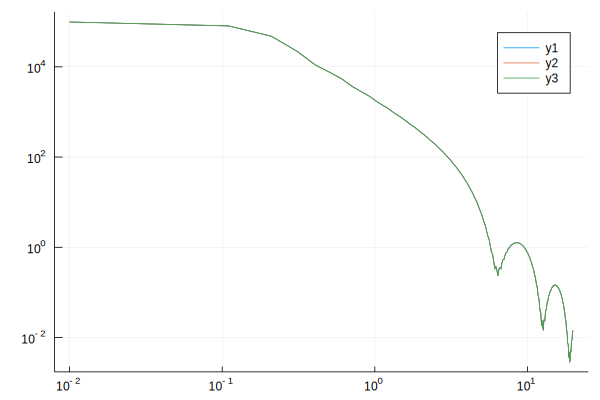

In [59]:
plot(qs, F2oa, xaxis=:log, yaxis=:log)
plot!(qs, F2oac, xaxis=:log, yaxis=:log)
plot!(qs, F2oc, xaxis=:log, yaxis=:log)
# plot!(qs, F2orawtz, xaxis=:log, yaxis=:log)
# plot!(qs, F2orawg, xaxis=:log, yaxis=:log)
# plot!(qs, F2obare, xaxis=:log, yaxis=:log)
# plot!(qs, F2obare2, xaxis=:log, yaxis=:log)
# plot!(qs, F2obare3, xaxis=:log, yaxis=:log)

#### 2. Testing translation of a cylinder on isotropic form factor

In [62]:
r0 = [0.0, 0, 0]
R0 = RotationMatrix(EulerAngle(0.0, 0.0, 0.0))
c0 = Cylinder(10.0, 1.0, 1.0, 1.0, r0, R0)
# translate the original cylinder to location [1, 1, 1]
t = [1, 1, 1]
ct = Scattering.translate(c0, t)

Cylinder{Float64}(10.0, 1.0, 314.1592653589793, 1.0, 1.0, [1.0, 1.0, 1.0], RotationMatrix{Float64}(Real[0.0, 0.0, 0.0], [1.0 -0.0 0.0; 0.0 1.0 0.0; -0.0 0.0 1.0]))

In [84]:
qs = 0.01:0.1:20
F2o0 = [orientation_average((θ,φ)->F2(θ,φ,c0,q), algo=HCubature2D()) for q in qs];
F2ot = [orientation_average((θ,φ)->F2(θ,φ,ct,q), algo=HCubature2D()) for q in qs];

In [86]:
@test F2o0 ≈ F2ot

Test Passed

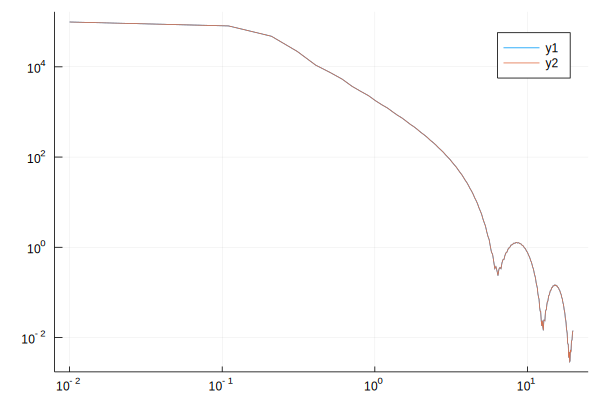

In [87]:
# Visual check that isotropic form factors are the same
plot(qs, F2o0, xaxis=:log, yaxis=:log)
plot!(qs, F2ot, xaxis=:log, yaxis=:log)

#### 2. Testing rotation of a cylinder on isotropic form factor

In [89]:
# Rotate a cylinder
M = RotationMatrix(EulerAngle(π/2, π/2, π/2))
cr = Scattering.rotate(c0, M)

Cylinder{Float64}(10.0, 1.0, 314.1592653589793, 1.0, 1.0, [0.0, 0.0, 0.0], RotationMatrix{Float64}(Real[1.5707963267948968, 1.5707963267948966, 1.5707963267948968], [-1.0 6.123233995736766e-17 -6.123233995736766e-17; -6.123233995736766e-17 -6.123233995736766e-17 1.0; 6.123233995736766e-17 1.0 6.123233995736766e-17]))

In [97]:
# Rotation is much harder to compute, use HCubature2D failed to converge.
# Use Trapz at both dimension instead, but have to run very long time.
# Caution: this line may wait very long (> 30 min) to complete
F2or = [orientation_average((θ,φ)->F2(θ,φ,cr,q), Nθ=1000, Nφ=2000, algo=Scattering.default(GeneralAlgorithm(),2)) for q in qs];

In [104]:
@test F2o0 ≈ F2or rtol=1e-6

Test Passed

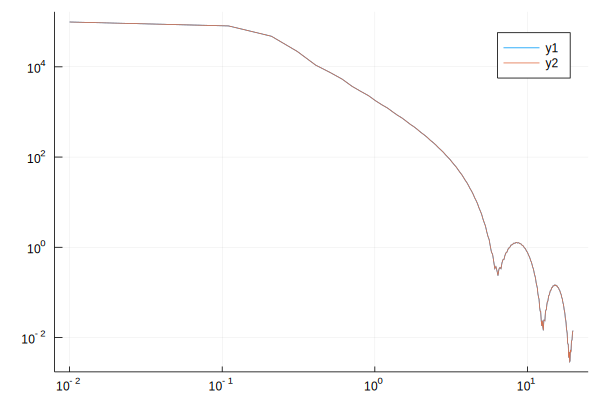

In [105]:
# Visual check that isotropic form factors are the same
# Rotation should have no effect on the isotropic form factor
plot(qs, F2o0, xaxis=:log, yaxis=:log)
plot!(qs, F2or, xaxis=:log, yaxis=:log)

### Testing form factor of a cyliner for size polydispersity

In [135]:
qs = 0.1:0.1:5
r0 = [0.0, 0, 0]
R0 = RotationMatrix(EulerAngle(0.0, 0.0, 0.0))
c0 = Cylinder(2.0, 3.0, 1.0, 1.0, r0, R0)

Cylinder{Float64}(2.0, 3.0, 37.69911184307752, 1.0, 1.0, [0.0, 0.0, 0.0], RotationMatrix{Float64}(Real[0.0, 0.0, 0.0], [1.0 -0.0 0.0; 0.0 1.0 0.0; -0.0 0.0 1.0]))

In [138]:
function F2(θ, φ, c, r, l, q)
    cr = Cylinder(r, l, c.ρ, c.Δρ, c.origin, c.orientation)
    formfactor_squared(cr, QVector([-q*sin(θ)*cos(φ),q*sin(θ)*sin(φ),q*cos(θ)]))
end

F2o(c,r,l,q) = orientation_average((θ,φ)->F2(θ,φ,c,r,l,q), algo=HCubature2D())

@time F2o0 = [orientation_average((θ,φ)->F2(θ,φ,c0,q), algo=HCubature2D()) for q in qs];

σR = 0.1
σL = 0.4
dr = Normal(c0.R, σR)
dl = Normal(c0.L, σL)
# Default number of points: 11, default algorithm QuadGKGauss
@time F2odr = [size_average(r->F2o(c0,r,c0.L,q), c0.R-2.5σR, c0.R+2.5σR, dr) for q in qs];
@time F2odl = [size_average(l->F2o(c0,c0.R,l,q), c0.L-2.5σL, c0.L+2.5σL, dl) for q in qs];
a = SVector{2}([c0.R-2.5σR, c0.L-2.5σL])
b = SVector{2}([c0.R+2.5σR, c0.L+2.5σL])
d = [dr, dl]
algo = GaussianProduct2D(QuadGKGauss(), QuadGKGauss())
@time F2odrl = [size_average((r,l)->F2o(c0,r,l,q), a, b, d, algo=algo) for q in qs];

  0.567435 seconds (3.97 M allocations: 155.814 MiB, 13.24% gc time)
  2.852758 seconds (38.72 M allocations: 1.413 GiB, 20.57% gc time)
  2.492869 seconds (38.01 M allocations: 1.377 GiB, 22.79% gc time)
 28.071994 seconds (420.05 M allocations: 15.190 GiB, 22.94% gc time)


In [144]:
start = 10
plot(qs[start:end], F2o0[start:end], xaxis=:log, yaxis=:log)
plot!(qs[start:end], F2odr[start:end], xaxis=:log, yaxis=:log)
plot!(qs[start:end], F2odl[start:end], xaxis=:log, yaxis=:log)
plot!(qs[start:end], F2odrl[start:end], xaxis=:log, yaxis=:log)

In [141]:
length(qs)

50

### Testing Special Functions

In [63]:
besselj1(1e-15)/1e-15

0.5

In [64]:
sinc(1/π)

0.8414709848078965

In [65]:
sin(1)

0.8414709848078965

In [66]:
qq = [1.0, 2.0, 3.0]
@test norm(qq[1:2]) ≈ √(qq[1]^2 + qq[2]^2)

Test Passed

In [67]:
maximum(qq)

3.0

In [68]:
zero(1.0)

0.0

In [69]:
F2oa[1]

98531.41373239426

In [70]:
f(x) = x^2
trapz(f, 1.0, 3.0, 5) - (9-1.0/3)

0.08333333333333393

In [71]:
range1 = collect(0.01:0.02:5)
range2 = collect(range(0.013, 2, length=100))

100-element Array{Float64,1}:
 0.013              
 0.03307070707070707
 0.05314141414141414
 0.07321212121212121
 0.09328282828282829
 0.11335353535353536
 0.13342424242424242
 0.1534949494949495 
 0.17356565656565656
 0.19363636363636363
 0.2137070707070707 
 0.23377777777777778
 0.2538484848484848 
 ⋮                  
 1.7792222222222223 
 1.7992929292929294 
 1.8193636363636363 
 1.8394343434343434 
 1.8595050505050505 
 1.8795757575757577 
 1.8996464646464646 
 1.9197171717171717 
 1.9397878787878788 
 1.959858585858586  
 1.9799292929292929 
 2.0                

In [72]:
(c0.V*c0.Δρ)^2

98696.04401089359

In [73]:
(π*c0.R^2*c0.L)^2

98696.04401089359

In [74]:
f(algo::Symbol) = println(algo)
f(:GaussianProduct)

GaussianProduct


In [75]:
algo = :HCubature
algo == :Hcubature

false

In [76]:
algo_set = Set((:HCubature, :GassianProduct))
algo ∈ algo_set

true

In [77]:
function isalgo(algo::Symbol)
    algo_set = Set((:HCubature, :GaussianProduct))
    @assert(algo ∈ algo_set, "$algo is not a valid quadrature algorithms. Try one of $algo_set.")
    algo ∈ algo_set
end
isalgo(:Trapz)
isalgo(:HCubature)
isalgo(:GaussianProduct)

AssertionError: AssertionError: Trapz is not a valid quadrature algorithms. Try one of Set(Symbol[:GaussianProduct, :HCubature]).

In [78]:
print(AlgorithmSet)

UndefVarError: UndefVarError: AlgorithmSet not defined

In [79]:
const AAA = Set((:xx, :yy))

Set(Symbol[:xx, :yy])

In [80]:
:xx ∈ AAA

true

In [81]:
isalgo2 = isalgo

isalgo (generic function with 1 method)

In [ ]:
isalgo2(:HCubature)

In [ ]:
struct MyType end

In [ ]:
mt = MyType()

In [ ]:
typeof(mt)